# Trabajo Práctico 2: Análisis con Redes Neuronales - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba

## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

In [3]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import normalizar_datos
from preprocessing import aplicar_one_hot_encoding

In [4]:
from funciones_auxiliares import graficar_auc_roc
from funciones_auxiliares import traer_df

In [5]:
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2

Además, declaramos la función para plotear la pérdida durante el entrenamiento de la red:

In [6]:
def graficar_perdida_modelo(history):
    plt.figure(dpi=125, figsize=(7, 2))
    plt.plot(history.history['loss'], label="Training loss")
    plt.plot(history.history['val_loss'], label="Validation loss")
    plt.title('Loss del modelo')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

## Carga del set de datos
Cargamos el dataset y aplicamos las funciones necesarias para adecuarlo al modelo:

In [7]:
df = traer_df()
df = preparar_dataset(df)
df = aplicar_one_hot_encoding(df)

También segmentamos el dataset en X e y (target), y luego lo dividimos en subsets de entrenamiento y validation development (test)

In [8]:
X, y = dividir_dataset(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

Creamos la red neuronal, con una capa de 13 neuronas (equivalente a la cantidad de features) de input, y función de activación 'tanh'. También hay una capa oculta de 8 neuronas, con activación 'tanh'. Agregamos capas de Dropout para regularizar la red, además de regularización L2. La capa de salida tiene función de activación sigmoide, con 1 neurona.

In [9]:
red_neuronal = Sequential()
red_neuronal.add(Dense(13, input_dim=50, activation='tanh', kernel_regularizer=l2(0.001)))
red_neuronal.add(Dropout(0.25))
red_neuronal.add(Dense(8, activation='tanh', kernel_regularizer=l2(0.001)))
red_neuronal.add(Dropout(0.25))
red_neuronal.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

Definimos el optimizador a utilizar, en este caso elegimos Adam, con un learning rate de 0.00001. Luego, compilamos la red con ese optimizador y la función de pérdida binary_crossentropy, ya que es una clasificación binaria. Además, mostramos el resumen de la red.

In [10]:
optimizador = keras.optimizers.Adam(learning_rate=0.00001)
red_neuronal.compile(loss="binary_crossentropy", optimizer=optimizador, metrics=[keras.metrics.AUC()])
red_neuronal.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 13)                663       
_________________________________________________________________
dropout (Dropout)            (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 112       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 784
Trainable params: 784
Non-trainable params: 0
_________________________________________________________________


El modelo necesita los labels en one hot encoding, usamos la función to_categorical para transformarlos

In [11]:
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

A continuación, entrenamos la red durante 500 epochs:

In [12]:
history = red_neuronal.fit(
    X_train.values, y_train.argmax(axis=1), epochs=500, validation_data=(X_test.values, y_test.argmax(axis=1)), verbose=0
)

Y realizamos la predicción sobre los datos de test y train:

In [13]:
y_pred = red_neuronal.predict(X_test)

Mostramos el gráfico de la ROC curve con su respectivo score en la métrica AUC-ROC:

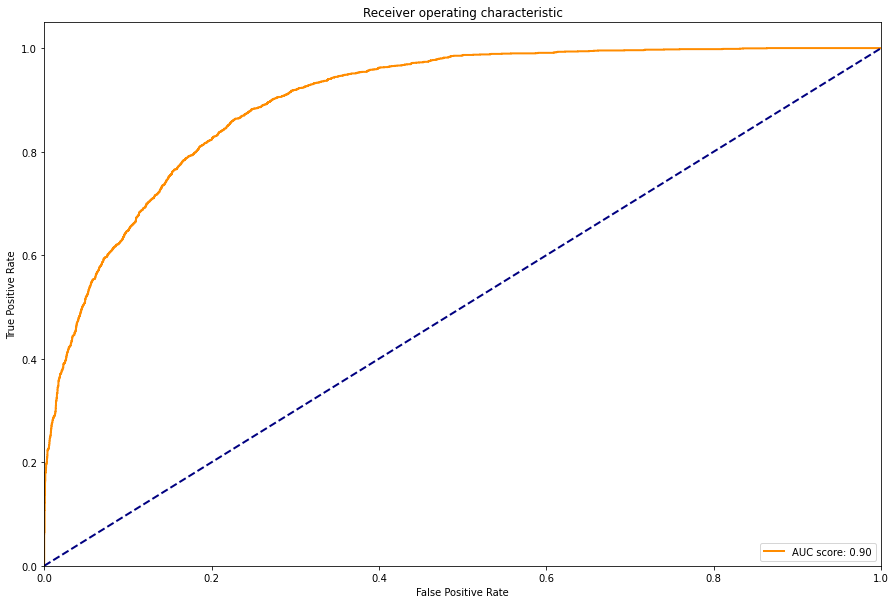

El valor de la metrica AUC-ROC para este modelo es: 0.900391629714497


In [14]:
graficar_auc_roc(y_test.argmax(axis=1), y_pred)

Se puede ver un score muy alto para la red, prácticamente 0.90

Luego, graficamos la pérdida del modelo a lo largo de los epochs, tanto de training como de validation:

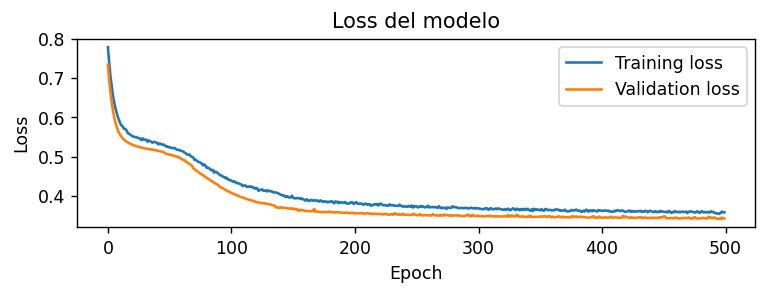

In [15]:
graficar_perdida_modelo(history)

Vemos que las pérdidas de validation y training van prácticamente a la par. Esto tiene sentido, ya que utilizamos dos métodos de regularización para evitar el overfitting (L2 y capas de Dropout).

A continuación, imprimimos el classification report correspondiente.

In [16]:
print(classification_report(y_test.argmax(axis=1), y_pred.round(), target_names=['No Tiene Alto Valor Adquisitivo','Tiene Alto Valor Adquisitivo']))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.88      0.93      0.90      6181
   Tiene Alto Valor Adquisitivo       0.73      0.59      0.65      1960

                       accuracy                           0.85      8141
                      macro avg       0.80      0.76      0.78      8141
                   weighted avg       0.84      0.85      0.84      8141



Por último, mostramos la matriz de confusión correspondiente:

In [17]:
from funciones_auxiliares import graficar_matriz_confusion

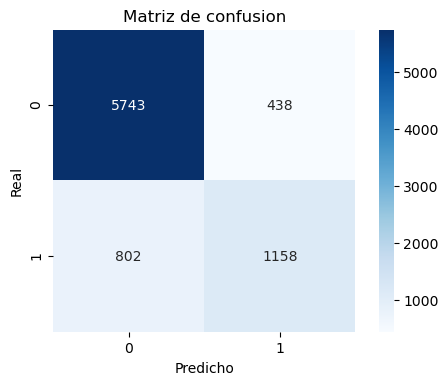

In [18]:
graficar_matriz_confusion(y_test.argmax(axis=1), y_pred.round())

Se puede observar un muy buen f1-score para las instancias de bajo valor adquisitivo, se podría decir que las clasifica bastante bien. Por otra parte, para las instancias de altos ingresos, se puede ver una precision relativamente alta (0.72) en comparación a otros modelos, pero un recall regular. 

Cabe destacar que no se ve una tendencia muy clara del modelo a predecir alguna clase por sobre la otra.

## Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados. 

In [19]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [20]:
X_exp = expandir_dataset(X)
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y, test_size=0.25, random_state=0)

Esta vez, la red tiene una capa de input de 17 neuronas, que equivale a la cantidad de features del dataset expandido mediante clustering.

In [21]:
red_neuronal_exp = Sequential()
red_neuronal_exp.add(Dense(17, input_dim=54, activation='tanh', kernel_regularizer=l2(0.001)))
red_neuronal_exp.add(Dropout(0.25))
red_neuronal_exp.add(Dense(8, activation='tanh', kernel_regularizer=l2(0.001)))
red_neuronal_exp.add(Dropout(0.25))
red_neuronal_exp.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

In [22]:
red_neuronal_exp.compile(loss="binary_crossentropy", optimizer=optimizador, metrics=[keras.metrics.AUC()])
red_neuronal_exp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 17)                935       
_________________________________________________________________
dropout_2 (Dropout)          (None, 17)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 144       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,088
Trainable params: 1,088
Non-trainable params: 0
_________________________________________________________________


El modelo necesita los labels en one hot encoding, usamos la función to_categorical para transformarlos

In [23]:
y_exp_train = keras.utils.to_categorical(y_exp_train, 2)
y_exp_test = keras.utils.to_categorical(y_exp_test, 2)

A continuación, entrenamos la red durante 500 epochs:

In [24]:
history = red_neuronal_exp.fit(
    X_exp_train.values, y_exp_train.argmax(axis=1), epochs=500, 
    validation_data=(X_exp_test.values, y_exp_test.argmax(axis=1)), verbose=0
)

Y realizamos la predicción sobre los datos de test:

In [25]:
y_pred = red_neuronal_exp.predict(X_exp_test)

Mostramos el gráfico de la ROC curve con su respectivo score en la métrica AUC-ROC:

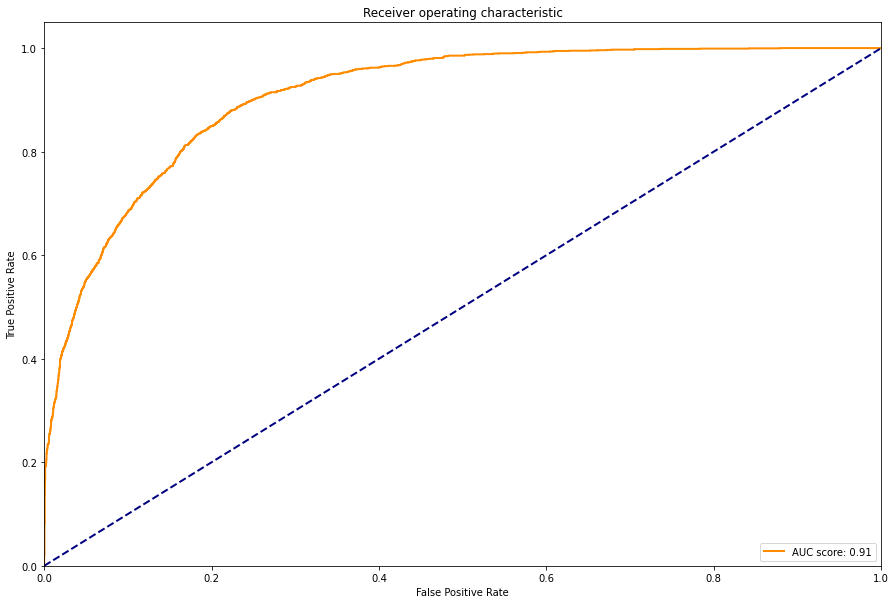

El valor de la metrica AUC-ROC para este modelo es: 0.9086423451590373


In [26]:
graficar_auc_roc(y_exp_test.argmax(axis=1), y_pred)

Se puede ver un AUC score un poco superior al de la red con el dataset original, ya que pasó de prácticamente un 0.90 a un 0.91. El añadido de nuevos features con clustering puede haber ayudado al modelo a una mejor clasificación. 

Luego, graficamos la pérdida del modelo a lo largo de los epochs, tanto de training como de validation:

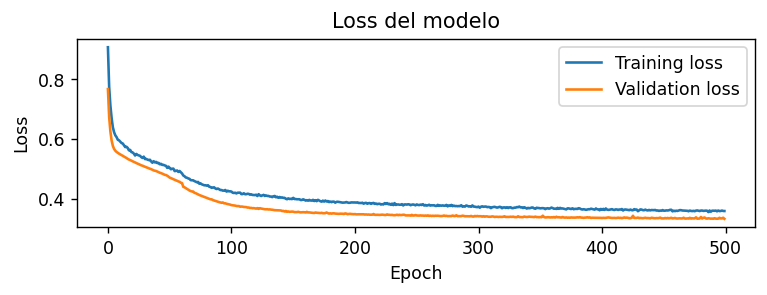

In [27]:
graficar_perdida_modelo(history)

Se puede observar que las pérdidas en los subsets de training y validation son similares, aunque ligeramente distanciadas.

A continuación, imprimimos el classification report correspondiente.

In [28]:
print(classification_report(y_exp_test.argmax(axis=1), y_pred.round(), target_names=['No Tiene Alto Valor Adquisitivo','Tiene Alto Valor Adquisitivo']))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo       0.88      0.93      0.90      6159
   Tiene Alto Valor Adquisitivo       0.73      0.62      0.67      1982

                       accuracy                           0.85      8141
                      macro avg       0.81      0.77      0.79      8141
                   weighted avg       0.85      0.85      0.85      8141



Por último, mostramos la matriz de confusión correspondiente:

In [29]:
from funciones_auxiliares import graficar_matriz_confusion

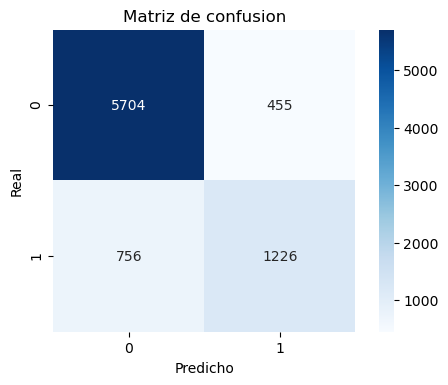

In [30]:
graficar_matriz_confusion(y_exp_test.argmax(axis=1), y_pred.round())

Vemos un ligero aumento en la precision y recall para las instancias que tienen alto valor adquisitivo, respecto al modelo prediciendo sobre el dataset original. El f1-score para los de bajos ingresos se mantiene prácticamente igual.

Tampoco se observa ninguna tendencia del modelo a predecir una clase sobre la otra.

## Predicción con el dataset nuevo
A continuación, realizamos la predicción con la red neuronal expandiendo el dataset sobre el dataset de predicciones nuevo, y la escribimos al archivo 'RedesNeuronales.csv'

In [31]:
from funciones_auxiliares import traer_df_predicciones
from preprocessing import preparar_df_predicciones
from funciones_auxiliares import escribir_predicciones

In [32]:
df_predicciones = traer_df_predicciones()
ids, df_predicciones = preparar_df_predicciones(df_predicciones)
df_predicciones = aplicar_one_hot_encoding(df_predicciones)
df_predicciones = expandir_dataset(df_predicciones)

In [79]:
predicciones = red_neuronal_exp.predict(df_predicciones)
escribir_predicciones(ids, predicciones.flatten().round().astype(int), "RedesNeuronales")